### Load Data

In [1]:
import pandas as pd

path = 'data/train.csv'
df = pd.read_csv(path)
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


### Outcome Distributions

Text(0.5, 1.0, 'outcome distribution')

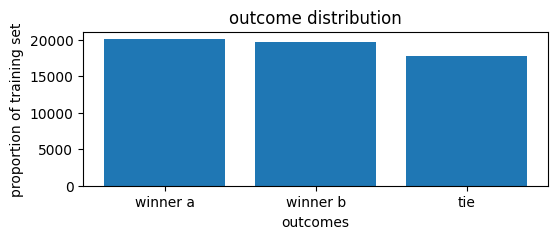

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,2))
plt.bar(['winner a', 'winner b', 'tie'], [df['winner_model_a'].sum(), 
                                          df['winner_model_b'].sum(), 
                                          df['winner_tie'].sum()])
plt.xlabel('outcomes')
plt.ylabel('proportion of training set')
plt.title('outcome distribution')

### Length Distributions

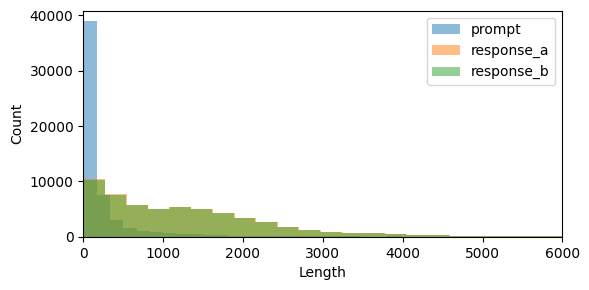

In [16]:
import matplotlib.pyplot as plt

# Compute string lengths
lengths = pd.DataFrame({
    "prompt": df["prompt"].str.len(),
    "response_a": df["response_a"].str.len(),
    "response_b": df["response_b"].str.len()
})

# Plot
plt.figure(figsize=(6, 3))
for col in lengths.columns:
    plt.hist(lengths[col], bins=200, alpha=0.5, label=col)
plt.legend()
plt.xlim([0, 6000])
plt.xlabel("Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Token Lengths Distribution

In [ ]:
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer
import pandas as pd

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Sample dataframe
df_ = df.sample(n = 100)

# Tokenize and get lengths
token_lengths = pd.DataFrame({
    "prompt": df_["prompt"].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True))),
    "response_a": df_["response_a"].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True))),
    "response_b": df_["response_b"].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
})

# Plot
plt.figure(figsize=(6, 3))
for col in token_lengths.columns:
    plt.hist(token_lengths[col], bins=200, alpha=0.5, label=col)

plt.legend()
plt.xlim([0, 600])
plt.xlabel("Token Count")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


c:\Users\zacco\OneDrive\Documents\Personal\Code\venvs\xpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (2396 > 512). Running this sequence through the model will result in indexing errors


### TF-IDF Distribution

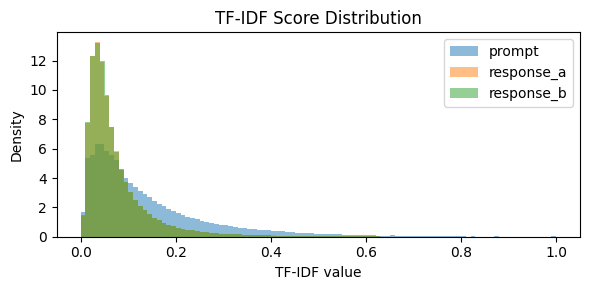

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Combine text columns
texts = {
    "prompt": df["prompt"].fillna("").tolist(),
    "response_a": df["response_a"].fillna("").tolist(),
    "response_b": df["response_b"].fillna("").tolist(),
}

plt.figure(figsize=(6, 3))

for col, corpus in texts.items():
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(corpus)
    tfidf_scores = X.data  # nonzero TF-IDF values
    plt.hist(tfidf_scores, bins=100, alpha=0.5, label=col, density=True)

plt.legend()
plt.xlabel("TF-IDF value")
plt.ylabel("Density")
plt.title("TF-IDF Score Distribution")
plt.tight_layout()
plt.show()


### TF-IDF w/ Winner

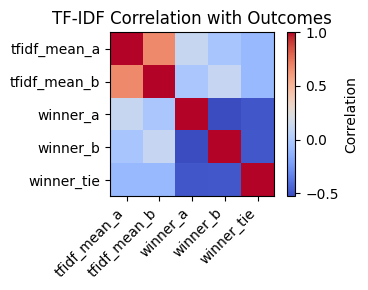

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Compute TF-IDF means without altering df
vectorizer_a = TfidfVectorizer(max_features=5000)
tfidf_a = vectorizer_a.fit_transform(df["response_a"].fillna(""))
tfidf_mean_a = tfidf_a.mean(axis=1).A1

vectorizer_b = TfidfVectorizer(max_features=5000)
tfidf_b = vectorizer_b.fit_transform(df["response_b"].fillna(""))
tfidf_mean_b = tfidf_b.mean(axis=1).A1

# Combine for correlation analysis
corr_df = pd.DataFrame({
    "tfidf_mean_a": tfidf_mean_a,
    "tfidf_mean_b": tfidf_mean_b,
    "winner_a": df["winner_model_a"],
    "winner_b": df["winner_model_b"],
    "winner_tie": df["winner_tie"],
})

corr = corr_df.corr()

# Plot correlation heatmap
plt.figure(figsize=(4, 3))
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("TF-IDF Correlation with Outcomes")
plt.tight_layout()
plt.show()
